# Import dataset and relevant libraries

In [4]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns 
import matplotlib.pyplot as plt 


In [5]:
df = pd.read_csv("drinking_water_potability.csv")

In [6]:
df.head(10)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.68774,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.71654,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.09176,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,NaN,118.988579,14285.58385,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.50849,9.077200,404.041635,563.885482,17.927806,71.976601,4.370562,0


# Exploring the dataset

## Looking for missing values and outliers

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [8]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [9]:
df.isnull().sum()/len(df)

ph                 0.149878
Hardness           0.000000
Solids             0.000000
Chloramines        0.000000
Sulfate            0.238400
Conductivity       0.000000
Organic_carbon     0.000000
Trihalomethanes    0.049451
Turbidity          0.000000
Potability         0.000000
dtype: float64

- Pour Thrihalomethanes, moins de 5% des lignes sont manquantes. On pourrait drop ces lignes sans trop impacter notre dataset
- Cependant pour PH et Sulfate il y a beaucoup trop de valeurs manquantes donc il faudra les remplacer. Soit vérifier si cela provient de la valeur d'une autre variable et l'utiliser pour remplacer les valeurs manquantes, soit utiliser la mediane ou la moyenne


In [10]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690300,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833605,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762125,8.114887,359.950170,481.792305,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196010,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


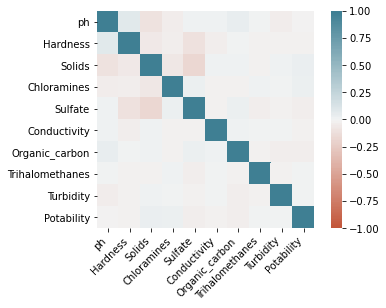

In [11]:
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [12]:
df[df.ph.isnull()]

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.318980,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
8,NaN,118.988579,14285.583850,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
13,NaN,150.174923,27331.361960,6.838223,299.415781,379.761835,19.370807,76.509996,4.413974,0
20,NaN,227.435048,22305.567410,10.333918,NaN,554.820087,16.331693,45.382815,4.133423,0
22,NaN,215.977859,17107.224230,5.607060,326.943978,436.256194,14.189062,59.855476,5.459251,0
...,...,...,...,...,...,...,...,...,...,...
3224,NaN,198.218700,31081.735260,7.419106,NaN,517.925946,11.711419,85.428785,3.345543,1
3229,NaN,203.204659,10643.186770,6.828936,NaN,384.597711,16.011328,72.911573,3.065910,1
3231,NaN,225.754109,28194.452650,5.892830,366.201583,418.272901,17.306832,103.912548,3.855895,1
3245,NaN,188.536608,24711.414930,7.129520,NaN,555.548534,16.959269,56.038702,4.331691,1


- Regarding the PH as we can see there are no variables really correlated with the PH. We could do either replace the missing values by the mean or median, or we could do something a little bit more meaningful. We have the WHO recommendations regarding the PH of potable water. We could replace the missing values by these recommended values so it could make more sense regarding our use case.

In [13]:
df[df.Sulfate.isnull()]

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
11,7.974522,218.693300,18767.65668,8.110385,NaN,364.098230,14.525746,76.485911,4.011718,0
14,7.496232,205.344982,28388.00489,5.072558,NaN,444.645352,13.228311,70.300213,4.777382,0
16,7.051786,211.049406,30980.60079,10.094796,NaN,315.141267,20.397022,56.651604,4.268429,0
...,...,...,...,...,...,...,...,...,...,...
3266,8.372910,169.087052,14622.74549,7.547984,NaN,464.525552,11.083027,38.435151,4.906358,1
3272,7.808856,193.553212,17329.80216,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.57822,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.86938,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


- Same thing as for the PH. There is no obvious correlated variable in the dataset with the SULFATE. Therefore, we could either replace the values by the mean or median, or we could replace it with recommendations by WHO so it makes more sense with our use case.

- Ultimately we can train our model on a dataset with the values filled with the mean(or median) and another model on a dataset filled with the WHO proposed values  

## Visualisations du jeu de données

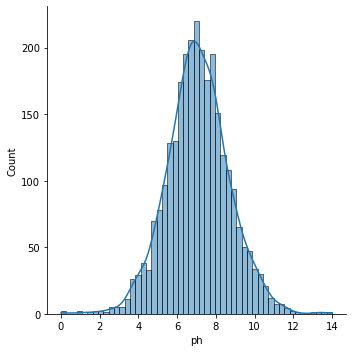

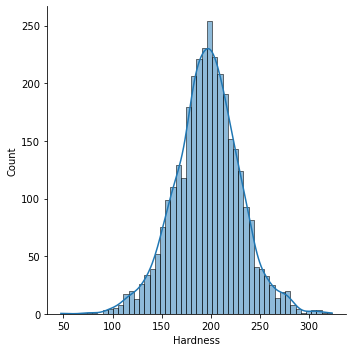

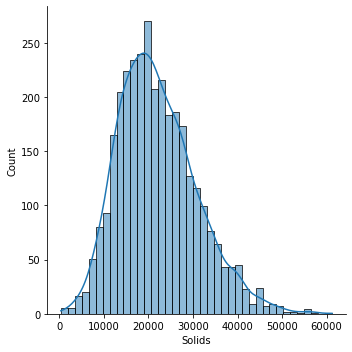

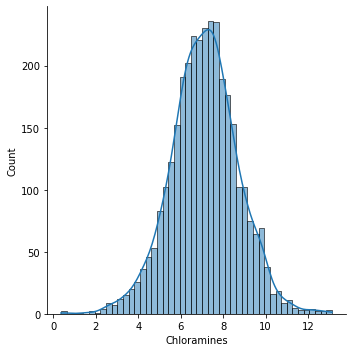

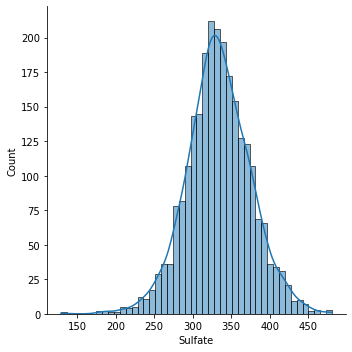

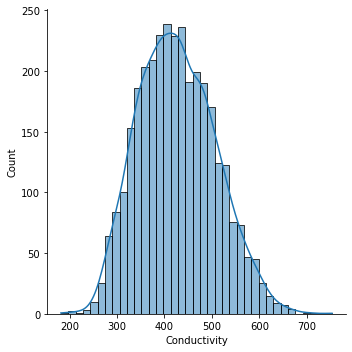

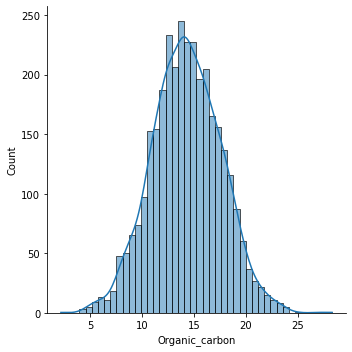

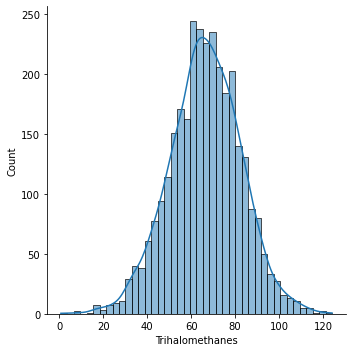

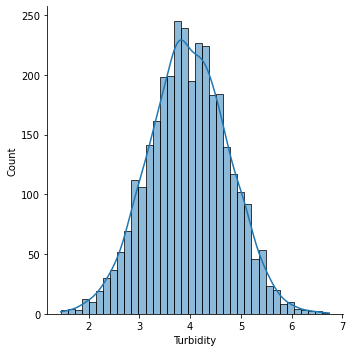

In [14]:
# Analyse de la distribution des variables

for axis in df.columns: 
    if axis != 'Potability':
        sns.displot(df[axis], kde= True)
plt.show()

>- Toutes les variables continues semblent suivre une loi normale, et ne pas comporter de valeurs aberrantes. Elles semblent cependant présenter une faible corrélation avec la cible. 


In [15]:
# Valeurs aberrrantes ? 

## Preprocessing 

## Entraînement du modèle 

In [16]:
df.fillna(df.mean(), inplace = True)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [18]:
## Quick preprocessing

#preprocessing_pipe = Pipeline([
#    ('missing', SimpleImputer(strategy="mean")),
#    ('std_scaler', StandardScaler())])
#preprocessing_pipe.fit_transform(X_train, y_train)

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

In [19]:
X_train

array([[ 1.26769657,  0.10691607, -0.19005424, ...,  1.61190672,
        -0.1466912 , -0.99018192],
       [ 0.56967145, -0.76464802, -1.73936282, ...,  2.67703458,
         0.46889155,  0.3937427 ],
       [-1.30097372,  0.08665108, -0.58085699, ..., -0.5435006 ,
        -0.00580696,  1.12822265],
       ...,
       [-0.00502064, -1.62854396,  2.64852823, ...,  1.91005178,
         0.23712198,  0.82522732],
       [-1.52572393,  0.29672305, -0.48344051, ..., -1.00163841,
        -1.22132499,  1.58271384],
       [-0.00502064, -0.40698136,  0.99718713, ...,  0.12375925,
         2.55642618, -0.14268733]])

In [20]:
## Comparaison de trois modèles simples : régression logistique, random forest, et SVM 

clf_lr  = LogisticRegression(random_state=22, max_iter=2000)
clf_rf  = RandomForestClassifier(random_state=22)
clf_svc = SVC(random_state=22)


## Instanciation de paramètres pour Nested Cross-Validation

param_grid_lr  = {'solver': ['liblinear', 'lbfgs'],
                   'C': np.logspace(-4,2,9)}

param_grid_rf  = [{'n_estimators': [10, 50, 100, 250, 500, 1000],
                   'min_samples_leaf': [1, 3, 5],
                   'max_features': ['sqrt', 'log2']}]

param_grid_svc = [{'kernel': ['rbf'],
                   'C': np.logspace(-4, 4, 9),
                    'gamma': np.logspace(-4, 0, 4)},
                  {'kernel': ['linear'],
                   'C': np.logspace(-4, 4, 9)}]


In [22]:
## préparation de la cross validation croisée 

gridcvs = {}

for pgrid, clf, name in zip((param_grid_lr,
                             param_grid_rf, param_grid_svc),
                            (clf_lr, clf_rf, clf_svc),
                            ('LogisticRegression', 'RF', 'SVM')):

    gcv = GridSearchCV(clf,
                       pgrid,
                       cv=3,
                       refit=True)
    gridcvs[name] = gcv

In [23]:
gridcvs.items()

dict_items([('LogisticRegression', GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=2000, random_state=22),
             param_grid={'C': array([1.00000000e-04, 5.62341325e-04, 3.16227766e-03, 1.77827941e-02,
       1.00000000e-01, 5.62341325e-01, 3.16227766e+00, 1.77827941e+01,
       1.00000000e+02]),
                         'solver': ['liblinear', 'lbfgs']})), ('RF', GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=22),
             param_grid=[{'max_features': ['sqrt', 'log2'],
                          'min_samples_leaf': [1, 3, 5],
                          'n_estimators': [10, 50, 100, 250, 500, 1000]}])), ('SVM', GridSearchCV(cv=3, estimator=SVC(random_state=22),
             param_grid=[{'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                          'gamma': array([1.00000000e-04, 2.15443469e-03, 4.64158883e-02, 1.00000000e+00]),
                          'kernel': ['rbf']},
                      

In [24]:
## Evalutation des scores de Cross-validation imbriquée

outer_cv = StratifiedKFold(n_splits=3, shuffle=True)
outer_scores = {}

for name, gs in gridcvs.items():
    nested_score = cross_val_score(gs, 
                                   X_train, 
                                   y_train, 
                                   cv=outer_cv)
    outer_scores[name] = nested_score
    print(f'{name}: outer accuracy {100*nested_score.mean():.2f} +/- {100*nested_score.std():.2f}')
    

LogisticRegression: outer accuracy 61.98 +/- 0.10
RF: outer accuracy 67.67 +/- 0.85
SVM: outer accuracy 67.56 +/- 0.89


In [25]:
# Sélection et entraînement du meilleur algorithme, i.e celui avec le plus haut taux de bonnes précisions moyen et le plus faible écart-type.

from sklearn.metrics import accuracy_score

final_clf = gridcvs['RF']
final_clf.fit(X_train, y_train)

print(f'Best Parameters: {final_clf.best_params_}')

train_acc = accuracy_score(y_true=y_train, y_pred=final_clf.predict(X_train))
test_acc = accuracy_score(y_true=y_test, y_pred=final_clf.predict(X_test))

print(f'Training Accuracy: {100*train_acc:.2f}')
print(f'Test Accuracy: {100*test_acc:.2f}')

Best Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 1000}
Training Accuracy: 100.00
Test Accuracy: 64.02


In [26]:

# Test the linear regressor on the test data.
predictions = rf_pipe.predict(X_test)
accuracy=accuracy_score(y_test,predictions)
print(accuracy)

NameError: name 'predictions' is not defined

## Évaluation des performances

> - Matrice de confusion

In [28]:
y_pred=final_clf.predict(X_test)

pd.crosstab(y_test, y_pred)

col_0,0,1
Potability,,
0,336,37
1,199,84
